## Load the data file


Here we load the complete data file and then filter so we only have nuclei.  Looks like there are over 544 nuclei cells detected!

In [2]:
import pandas as pd
import os
from utility import compute_lsa_distance, find_scale_and_translation, calculate_jac
import numpy as np

data_file = r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\coordinate_data_deidentified.csv'

data = pd.read_csv(data_file)
print(data.shape)
#data = data[data.csv_path.str.contains('nuclei', na=False)]
print(data.shape)


(108703, 7)
(108703, 7)


## Load the ground truth data

In [3]:
ground_truth_file = r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\ground_truth_coords.csv'

ground_truth = pd.read_csv(ground_truth_file)
print(ground_truth.shape)

# Display the first few rows of the ground truth data
ground_truth['base_name'] = ground_truth['path'].apply(os.path.basename)
ground_truth.head()

(6024, 5)


,Unnamed: 0,x,y,z,path,base_name
0,0,5.628644,9.198676,8.751923,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif
1,1,22.816774,9.033185,6.689963,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif
2,2,22.618367,26.020343,15.707744,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif
3,3,13.676880,23.516335,14.263662,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif
4,4,25.001824,8.219340,21.236781,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif


## Create dictionary to link friendly name to the more detailed name

This is copied from the ```registration.py``` file provided by ABRF. 

In [4]:
from registration import friendly_names

print(friendly_names)

{'celegans_dyn-90_ceff-0_label.ics.ome.tiff': 'fish1', 'celegans_dyn-90_ceff-90_label.ics.ome.tiff': 'fish2', 'celegans_dyn-10_ceff-0_label.ics.ome.tiff': 'fish3', 'celegans_dyn-10_ceff-90_label.ics.ome.tiff': 'fish4', 'Q10.13': 'fish1', 'Q11.13': 'fish2', 'Q12.13': 'fish3', 'Q13.13': 'fish4', 'out_c00_dr10_label.tif': 'nuclei3', 'out_c00_dr90_label.tif': 'nuclei1', 'out_c90_dr10_label.tif': 'nuclei4', 'out_c90_dr90_label.tif': 'nuclei2', 'Q6.13': 'nuclei1', 'Q7.13': 'nuclei2', 'Q8.13': 'nuclei3', 'Q9.13': 'nuclei4'}


## Open combined data

Open the file (combined data deidentified.csv) containing the meta data, survey data and the metrics calculated by ABRF

In [5]:

combined_data = pd.read_csv(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\combined data deidentified.csv')
combined_data = combined_data[['responseid', 'qx.2','setName','lsa_mse_raw', 'lsa_mse_transformed']]

print(combined_data.shape)
# only keep rows where nuclei is in the setName
#combined_data = combined_data[combined_data.setName.str.contains('nuclei')]

print(combined_data.shape)
combined_data.head()

(159, 5)
(159, 5)


,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed
0,R_31bjqd6Mm8wBxN5,Python,nuclei1,182.451824,56.679462
1,R_31bjqd6Mm8wBxN5,Python,nuclei2,47.222279,21.174983
2,R_31bjqd6Mm8wBxN5,Python,nuclei3,105.577865,18.732895
3,R_31bjqd6Mm8wBxN5,Python,nuclei4,88.287150,19.067347
4,R_3lAJ9xY4kGlL99f,Python,nuclei1,565.205858,0.017590


In [17]:
from correction import apply_corrections

num_bad = 0
num_good = 0

answers = []

combined_data['lsa_mse_label_corrected'] = 0
combined_data['lsa_mse_label_and_image_corrected'] = 0
combined_data['best'] = 0
combined_data['correction'] = 'NONE'
combined_data['jac'] = 0

for index, row in combined_data.iterrows():

    responseid = row['responseid']
    print(f'Processing responseid: {responseid}')
    
    data_name = row['setName'].strip()
    test_data = data[data.csv_path.str.contains(responseid, na=False)]

    if test_data.shape[0] == 0:
        print(f'No test data found for responseid {responseid}')
        continue
    
    print('data name', data_name)
    unique_paths = test_data.csv_path.unique()

    #if 'fish' not in data_name:
    #    continue

    #if 'R_2DNRFrAvCDUX1EL' not in responseid:
    #    continue 
    #print(f'there are {len(unique_paths)} unique csv paths')

    key = next(k for k, v in friendly_names.items() if v == data_name)
    print(key)  # Output: 'out_c00_dr10_label.tif'

    data_to_find = test_data[test_data.csv_path.str.contains(data_name, na=False, case=False)]
    print(f'there are {data_to_find.shape[0]} rows for {data_name} in responseid {responseid}')

    if data_to_find.shape[0] == 0:
        print(f'No test data found for {data_name} in responseid {responseid}')
        continue
    print(f'there are {len(data_to_find.csv_path.unique())} unique test csv paths')

    gd = ground_truth[ground_truth['base_name'] == key]
    print(f'there are {gd.shape[0]} rows for {key}')

    name = data_to_find['csv_path'].iloc[0]
    td = data_to_find[data_to_find.csv_path == name]
    
    td = td[['x', 'y', 'z']].apply(pd.to_numeric, errors='coerce').fillna(0)

    # remove any zero rows from answer
    td = td[(td[['x', 'y', 'z']] != 0).any(axis=1)]

    a, b, lsa_mean = compute_lsa_distance(
        gd[['x', 'y', 'z']].values,
        td[['x', 'y', 'z']].fillna(0).values.astype(float)
    )
    print(f'lsa mean raw: {lsa_mean}')
   
    ground_truth_to_find_corrected = gd.copy()   
    
    if 'nuclei' in data_name: 
        ground_truth_to_find_corrected['z'] = gd['z']*(.124/.2)
    else:
        ground_truth_to_find_corrected['z'] = gd['z']*(.1616160/.2)
    
    ground_truth_to_find_corrected = ground_truth_to_find_corrected[['x', 'y', 'z']].fillna(0).astype(float)
    
    a_, b_, lsa_mean_label_spacings_corrected = compute_lsa_distance(
        ground_truth_to_find_corrected[['x', 'y', 'z']].values,
        td[['x', 'y', 'z']].fillna(0).values.astype(float)
    )

    print(f'lsa mean label spacings corrected: {lsa_mean_label_spacings_corrected}')
    
    answer_corrected, correction = apply_corrections(td, responseid, data_name)

    combined_data.loc[(combined_data['responseid'] == responseid) &
                        (combined_data['setName'] == data_name), 
                        'correction'] = correction
    a, b, lsa_mean_corrected = compute_lsa_distance(
        ground_truth_to_find_corrected.values,
        answer_corrected.values
    )

    #if correction == 'STOP': 
    scale, translation = find_scale_and_translation(ground_truth_to_find_corrected, answer_corrected, True)
    print(f'detected scale: {scale}, detected translation: {translation}')

    #answer_corrected['x']= answer_corrected['x']*scale[0,0] + translation[0,0]
    #answer_corrected['y']= answer_corrected['y']*scale[0,1] + translation[0,1]
    #answer_corrected['z']= answer_corrected['z']*scale[0,2] + translation[0,2]

    scale, translation = find_scale_and_translation(ground_truth_to_find_corrected, answer_corrected)
    print(f'detected scale: {scale}, detected translation: {translation}')
    #correction = "AUTOMATIC"

    

    if 'fish' in data_name:
        tp, fp, fn, jac = calculate_jac(
            ground_truth_to_find_corrected[['x', 'y', 'z']].values,
            answer_corrected[['x', 'y', 'z']].values, lsa=(a,b)
        )
        print(f'jac is {jac}, tp: {tp}, fp: {fp}, fn: {fn}')
    else:
        jac, tp, fp, fn = 0, 0, 0, 0 

      
    if lsa_mean_corrected < 1.0:
        num_good += 1
    else:
        num_bad += 1
    print(f'num_good: {num_good}, num_bad: {num_bad}')

    answers.append(lsa_mean_corrected)

    print(f'lsa mse raw: {lsa_mean}')
    print(f'lsa mse transformed: {lsa_mean_corrected}')
    print(f'jac: {jac}')
    print('=======================================================')

    # update the combined_data DataFrame with the computed values
    combined_data.loc[(combined_data['responseid'] == responseid) & 
                        (combined_data['setName'] == data_name), 
                        'lsa_mse_label_corrected'] = lsa_mean_label_spacings_corrected
    
    combined_data.loc[(combined_data['responseid'] == responseid) & 
                        (combined_data['setName'] == data_name), 
                        'lsa_mse_label_and_image_corrected'] = lsa_mean_corrected
    
    # best is min of lsa_mse_transformed and lsa_mse_transformed_alt
    combined_data.loc[(combined_data['responseid'] == responseid) & 
                        (combined_data['setName'] == data_name), 
                        'best'] =  combined_data[['lsa_mse_transformed', 'lsa_mse_label_and_image_corrected']].min(axis=1)
    
    combined_data.loc[(combined_data['responseid'] == responseid) &
                        (combined_data['setName'] == data_name), 
                        'jac'] = jac
    

Processing responseid: R_31bjqd6Mm8wBxN5
data name nuclei1
out_c00_dr90_label.tif
there are 5 rows for nuclei1 in responseid R_31bjqd6Mm8wBxN5
there are 1 unique test csv paths
there are 5 rows for out_c00_dr90_label.tif
lsa mean raw: 182.45182410581776
lsa mean label spacings corrected: 105.70139484108113
detected scale: [[1.00323818 1.00323818 1.00520221]], detected translation: [[-0.03374655  0.02866844 -0.02458869]]
detected scale: [[1.00323818 1.00323818 1.00520221]], detected translation: [[-0.03374655  0.02866844 -0.02458869]]
num_good: 1, num_bad: 0
lsa mse raw: 182.45182410581776
lsa mse transformed: 0.019770487442195044
jac: 0
Processing responseid: R_31bjqd6Mm8wBxN5
data name nuclei2
out_c90_dr90_label.tif
there are 5 rows for nuclei2 in responseid R_31bjqd6Mm8wBxN5
there are 1 unique test csv paths
there are 5 rows for out_c90_dr90_label.tif
lsa mean raw: 47.22227897631546
lsa mean label spacings corrected: 22.69394231924769
detected scale: [[0.99912468 0.99912468 1.0244609

C:\Users\bnort\AppData\Local\Temp\ipykernel_2900\2795499988.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '105.70139484108113' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_data.loc[(combined_data['responseid'] == responseid) &
C:\Users\bnort\AppData\Local\Temp\ipykernel_2900\2795499988.py:132: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.019770487442195044' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_data.loc[(combined_data['responseid'] == responseid) &
C:\Users\bnort\AppData\Local\Temp\ipykernel_2900\2795499988.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01977049]' has dtype incompatible with int64, please expli

lsa mean raw: 565.2058581880239
lsa mean label spacings corrected: 457.8904940741767
detected scale: [[1.00366614 1.00366614 1.01980049]], detected translation: [[-0.15646795 -0.01690999  0.04452627]]
detected scale: [[1.00366614 1.00366614 1.01980049]], detected translation: [[-0.15646795 -0.01690999  0.04452627]]
num_good: 5, num_bad: 0
lsa mse raw: 565.2058581880239
lsa mse transformed: 0.07075414249225555
jac: 0
Processing responseid: R_3lAJ9xY4kGlL99f
data name nuclei2
out_c90_dr90_label.tif
there are 5 rows for nuclei2 in responseid R_3lAJ9xY4kGlL99f
there are 1 unique test csv paths
there are 5 rows for out_c90_dr90_label.tif
lsa mean raw: 382.36635822750145
lsa mean label spacings corrected: 297.2166670708351
detected scale: [[1.0306694  1.0306694  0.99961107]], detected translation: [[-0.34364763 -0.44073383  0.17640124]]
detected scale: [[1.0306694  1.0306694  0.99961107]], detected translation: [[-0.34364763 -0.44073383  0.17640124]]
num_good: 6, num_bad: 0
lsa mse raw: 382.

C:\Users\bnort\AppData\Local\Temp\ipykernel_2900\2795499988.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9586942038640907' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_data.loc[(combined_data['responseid'] == responseid) &


lsa mean raw: 647.8575953295806
lsa mean label spacings corrected: 647.9298010624765
detected scale: [[0.99313043 0.99313043 0.97635834]], detected translation: [[-0.06667499  0.29991406  0.01797729]]
detected scale: [[0.99313043 0.99313043 0.97635834]], detected translation: [[-0.06667499  0.29991406  0.01797729]]
jac is 0.8767488341105929, tp: 1316, fp: 89, fn: 96
num_good: 9, num_bad: 1
lsa mse raw: 647.8575953295806
lsa mse transformed: 2.0840090088893595
jac: 0.8767488341105929
Processing responseid: R_3lAJ9xY4kGlL99f
data name fish3
celegans_dyn-10_ceff-0_label.ics.ome.tiff
there are 1759 rows for fish3 in responseid R_3lAJ9xY4kGlL99f
there are 1 unique test csv paths
there are 1501 rows for celegans_dyn-10_ceff-0_label.ics.ome.tiff
lsa mean raw: 394.3157724605201
lsa mean label spacings corrected: 393.7866103216592
detected scale: [[0.99956399 0.99956399 0.99632205]], detected translation: [[-0.0598357  -0.04854492  0.00671338]]
detected scale: [[0.99956399 0.99956399 0.99632205

c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bnort\miniconda3\e

detected scale: [[nan nan nan]], detected translation: [[nan nan nan]]
detected scale: [[nan nan nan]], detected translation: [[nan nan nan]]
num_good: 50, num_bad: 8
lsa mse raw: nan
lsa mse transformed: nan
jac: 0
Processing responseid: R_24Nwgngl83ucQ8B
data name fish1
celegans_dyn-90_ceff-0_label.ics.ome.tiff
there are 0 rows for fish1 in responseid R_24Nwgngl83ucQ8B
No test data found for fish1 in responseid R_24Nwgngl83ucQ8B
Processing responseid: R_24Nwgngl83ucQ8B
data name fish4
celegans_dyn-10_ceff-90_label.ics.ome.tiff
there are 0 rows for fish4 in responseid R_24Nwgngl83ucQ8B
No test data found for fish4 in responseid R_24Nwgngl83ucQ8B
Processing responseid: R_1F9A4K8LNlJoksJ
data name nuclei1
out_c00_dr90_label.tif
there are 5 rows for nuclei1 in responseid R_1F9A4K8LNlJoksJ
there are 1 unique test csv paths
there are 5 rows for out_c00_dr90_label.tif
lsa mean raw: 29.160129251902653
lsa mean label spacings corrected: 0.06838237460909938
detected scale: [[1.00716311 1.00716

In [27]:
combined_data.head()

,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed,lsa_mse_label_corrected,lsa_mse_label_and_image_corrected,best,correction,jac
0,R_31bjqd6Mm8wBxN5,Python,nuclei1,182.451824,56.679462,0.0,0.0,0.0,NONE,0.0
1,R_31bjqd6Mm8wBxN5,Python,nuclei2,47.222279,21.174983,0.0,0.0,0.0,NONE,0.0
2,R_31bjqd6Mm8wBxN5,Python,nuclei3,105.577865,18.732895,0.0,0.0,0.0,NONE,0.0
3,R_31bjqd6Mm8wBxN5,Python,nuclei4,88.287150,19.067347,0.0,0.0,0.0,NONE,0.0
4,R_3lAJ9xY4kGlL99f,Python,nuclei1,565.205858,0.017590,0.0,0.0,0.0,NONE,0.0


In [22]:
combined_data.to_csv(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\combined_data_deidentified_with_lsa_mse_transformed_alt7.csv', index=False)

In [42]:
cd_imaris_arivis_aivia = combined_data[combined_data['qx.2'].str.contains('Imaris', na=False) |
                                        combined_data['qx.2'].str.contains('Arivis', na=False) |
                                        combined_data['qx.2'].str.contains('Aivia', na=False)]

print(cd_imaris_arivis_aivia.shape)

(79, 10)


In [43]:
cd_imaris_arivis_aivia = cd_imaris_arivis_aivia.dropna()
cd_imaris_arivis_aivia

,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed,lsa_mse_label_corrected,lsa_mse_label_and_image_corrected,best,correction,jac
21,R_2rCMx6wAGE7bFJh,"Imaris (Bitplane),NIS Elements (Nikon)",nuclei1,4.614994,0.011627,0.000000,0.000000,0.000000,NONE,0.000000
22,R_2rCMx6wAGE7bFJh,"Imaris (Bitplane),NIS Elements (Nikon)",nuclei2,35.217271,0.046564,0.000000,0.000000,0.000000,NONE,0.000000
23,R_2rCMx6wAGE7bFJh,"Imaris (Bitplane),NIS Elements (Nikon)",nuclei3,37.003434,0.059814,0.000000,0.000000,0.000000,NONE,0.000000
24,R_2rCMx6wAGE7bFJh,"Imaris (Bitplane),NIS Elements (Nikon)",nuclei4,155.450872,0.069777,0.000000,0.000000,0.000000,NONE,0.000000
25,R_2rCMx6wAGE7bFJh,"Imaris (Bitplane),NIS Elements (Nikon)",fish1,1.420323,0.030934,4.366843,4.366843,0.030934,NONE,0.407942
...,...,...,...,...,...,...,...,...,...,...
154,R_1GUZ4XruXifzoPp,Aivia,nuclei4,42.169642,0.187513,0.000000,0.000000,0.000000,NONE,0.000000
155,R_1GUZ4XruXifzoPp,Aivia,fish1,1.363420,0.007831,3.214236,3.214236,0.007831,NONE,0.887387
156,R_1GUZ4XruXifzoPp,Aivia,fish2,2.432072,0.009987,1.929821,1.929821,0.009987,NONE,0.948480
157,R_1GUZ4XruXifzoPp,Aivia,fish3,2.403677,0.013675,3.809483,3.809483,0.013675,NONE,0.863595


In [9]:
cd_fiji_imagej_python_cellprofiler = combined_data[combined_data['qx.2'].str.contains('Fiji', na=False) |
                                                  combined_data['qx.2'].str.contains('ImageJ', na=False) |
                                                  combined_data['qx.2'].str.contains('Python', na=False) |
                                                  combined_data['qx.2'].str.contains('Cell Profiler', na=False)]

In [10]:
cd_fiji_imagej_python_cellprofiler = cd_fiji_imagej_python_cellprofiler.dropna()
print(cd_fiji_imagej_python_cellprofiler.shape)
cd_fiji_imagej_python_cellprofiler

(44, 9)


,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed,lsa_mse_label_corrected,lsa_mse_label_and_image_corrected,best,correction
11,R_31bjqd6Mm8wBxN5,Python,nuclei1,182.451824,56.679462,105.701395,0.019770,0.019770,REVERSE_XY
12,R_31bjqd6Mm8wBxN5,Python,nuclei2,47.222279,21.174983,22.693942,0.019032,0.019032,REVERSE_XY
13,R_31bjqd6Mm8wBxN5,Python,nuclei3,105.577865,18.732895,72.880209,0.066909,0.066909,REVERSE_XY
14,R_31bjqd6Mm8wBxN5,Python,nuclei4,88.287150,19.067347,44.821824,0.020630,0.020630,REVERSE_XY
19,R_0638fJAPpmzLtu1,"Cell Profiler,Python",nuclei1,33946.444950,114.068490,33392.775375,0.227692,0.227692,PIXELS_TO_MICRONS
20,R_0638fJAPpmzLtu1,Cell Profiler,nuclei2,22860.828930,63.083559,23155.510627,0.728807,0.728807,PIXELS_TO_MICRONS
21,R_0638fJAPpmzLtu1,Cell Profiler,nuclei3,25600.556860,79.446807,25953.094940,4.280077,4.280077,PIXELS_TO_MICRONS
22,R_0638fJAPpmzLtu1,Cell Profiler,nuclei4,21265.066370,47.359510,21978.152395,2.550826,2.550826,PIXELS_TO_MICRONS
23,R_2cCJjlMU7i9XjMQ,FIJI/ImageJ,nuclei1,30.361420,0.012966,0.027356,0.027356,0.012966,NONE
25,R_2c14tLfUPR1Vnua,FIJI/ImageJ,nuclei1,27.147977,0.053978,0.081662,0.081662,0.053978,NONE


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_fig(col_name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

    sns.boxplot(cd_imaris_arivis_aivia[col_name].dropna(), showfliers=False, ax=axes[0])
    sns.stripplot(cd_imaris_arivis_aivia[col_name].dropna(), jitter=0.25, alpha=0.7, ax=axes[0])
    axes[0].set_title('MSE Imaris/Arivis/Aivia')
    axes[0].set_xlabel('')
    axes[0].set_yscale('log')
    axes[0].grid(True)

    #plt.figure(figsize=(4, 6))
    sns.boxplot(cd_fiji_imagej_python_cellprofiler[col_name].dropna(), showfliers=False, ax=axes[1])
    sns.stripplot(cd_fiji_imagej_python_cellprofiler[col_name].dropna(), jitter=0.25, alpha=0.7, ax=axes[1])
    axes[1].set_title('MSE Fiji/ImageJ/Python/CellProfiler')
    axes[1].set_xlabel('')
    axes[1].set_yscale('log')
    axes[1].grid(True)

    return(fig)

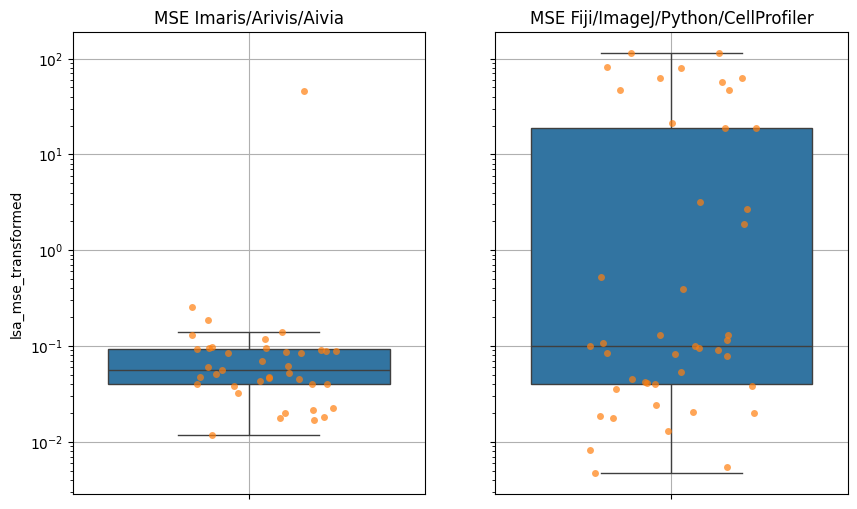

In [71]:
fig = make_fig('lsa_mse_transformed')
fig.savefig(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\lsa_mse_transformed_boxplot.png', dpi=300)

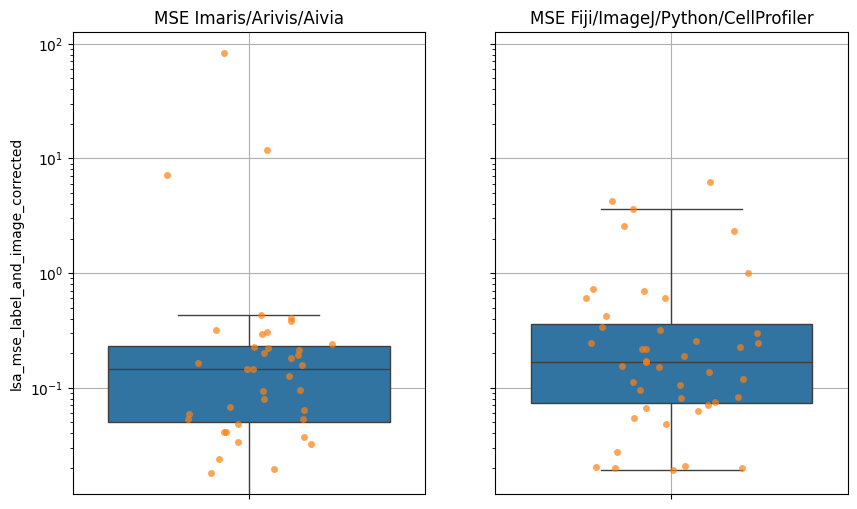

In [72]:
fig = make_fig('lsa_mse_label_and_image_corrected')
fig.savefig(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\lsa_mse_label_and_image_corrected_boxplot.png', dpi=300)

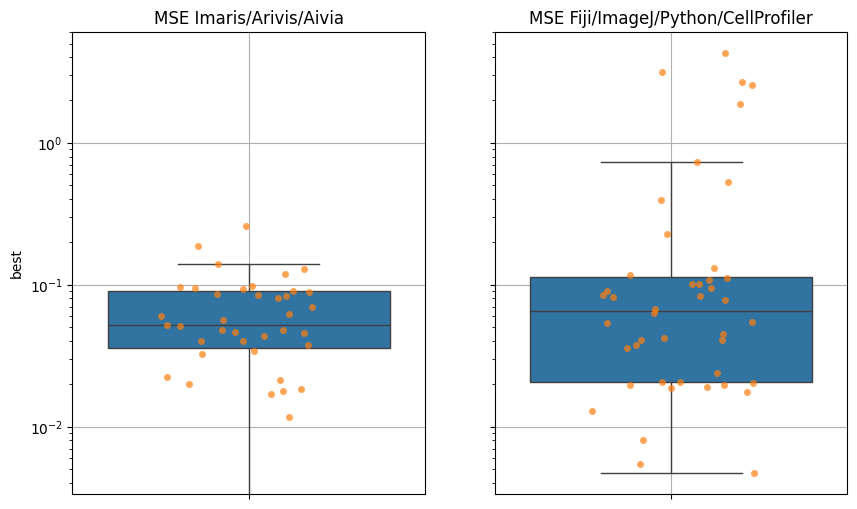

In [74]:
fig = make_fig('best')
fig.savefig(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\best_boxplot.png', dpi=300)

In [9]:
combined_data.head()

,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed,lsa_mse_label_corrected,lsa_mse_label_and_image_corrected,best,correction,jac
0,R_31bjqd6Mm8wBxN5,Python,nuclei1,182.451824,56.679462,105.701395,0.019770,0.019770,REVERSE_XY,0.0
1,R_31bjqd6Mm8wBxN5,Python,nuclei2,47.222279,21.174983,22.693942,0.019032,0.019032,REVERSE_XY,0.0
2,R_31bjqd6Mm8wBxN5,Python,nuclei3,105.577865,18.732895,72.880209,0.066909,0.066909,REVERSE_XY,0.0
3,R_31bjqd6Mm8wBxN5,Python,nuclei4,88.287150,19.067347,44.821824,0.020630,0.020630,REVERSE_XY,0.0
4,R_3lAJ9xY4kGlL99f,Python,nuclei1,565.205858,0.017590,457.890494,0.070754,0.017590,REVERSE_XY_SCALE4,0.0


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


df['qx.2'].unique()


NameError: name 'df' is not defined

In [14]:
df = combined_data


df3 = df
'''
df[(df['qx.2']=='Imaris (Bitplane),AutoQuantX') | (df['qx.2']=='NIS Elements (Nikon)') | (df['qx.2']=='Imaris (Bitplane)') | 
         (df['qx.2']=='Arivis') | (df['qx.2']=='Aivia') | (df['qx.2']=='FIJI/ImageJ') | (df['qx.2']=='ImageJ') | (df['qx.2']=='Python') | 
         (df['qx.2']=='Cell Profiler') | (df['qx.2']=='Cell Profiler,Python') | 
        (df['qx.2']=='Cell Profiler,ImageJ') | (df['qx.2']=='Cell Profiler,FIJI/ImageJ') | (df['qx.2']=='Cell Profiler,Python,ImageJ') |
        ( df['qx.2']=='Imaris (Bitplane),NIS Elements (Nikon)')
'''
df3.shape

(159, 10)

C:\Users\bnort\AppData\Local\Temp\ipykernel_20636\3078719350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tool'] = df["qx.2"].str.replace(' ', '\n')


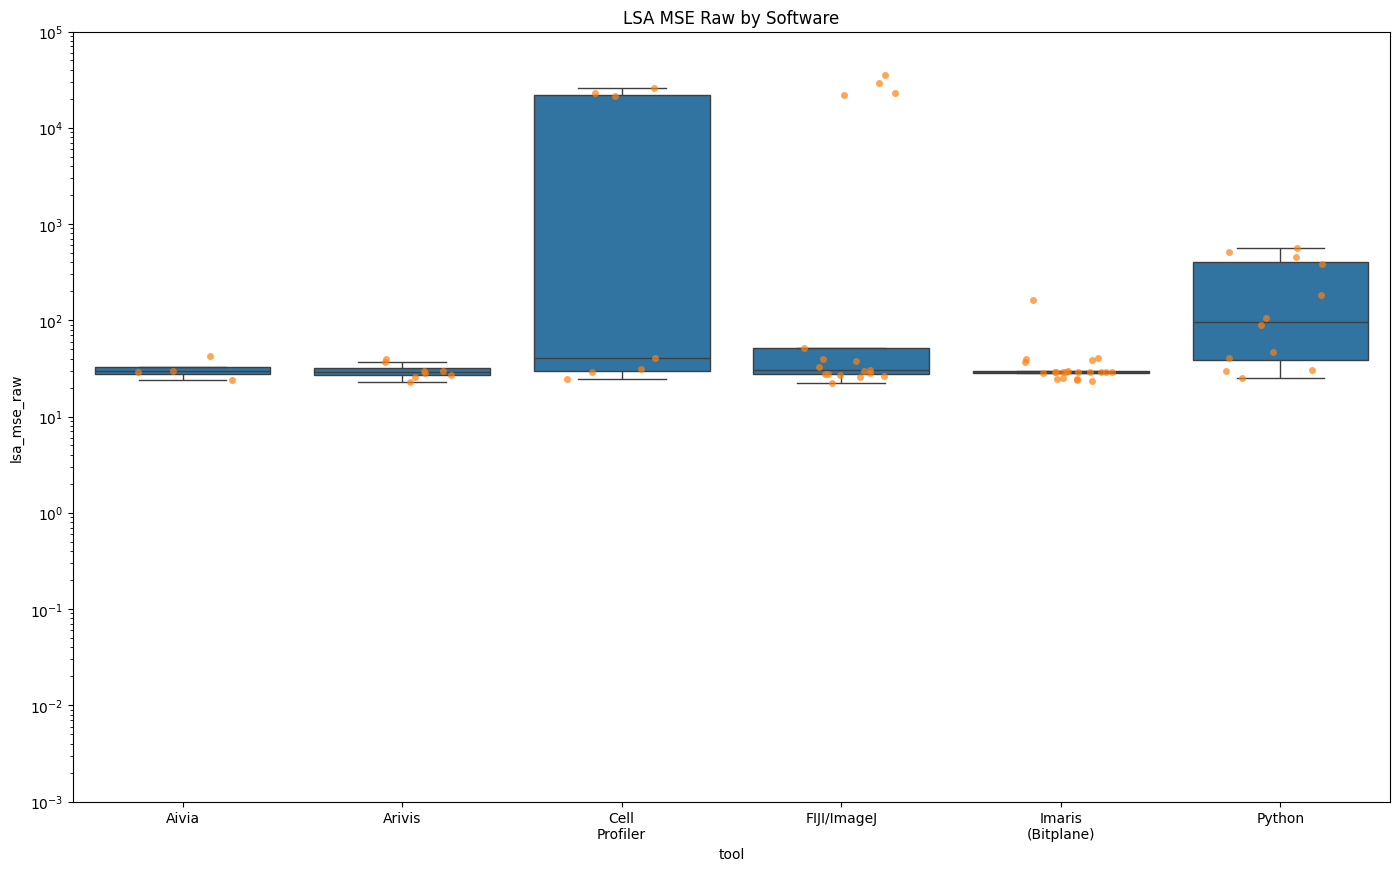

C:\Users\bnort\AppData\Local\Temp\ipykernel_20636\3078719350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tool'] = df["qx.2"].str.replace(' ', '\n')


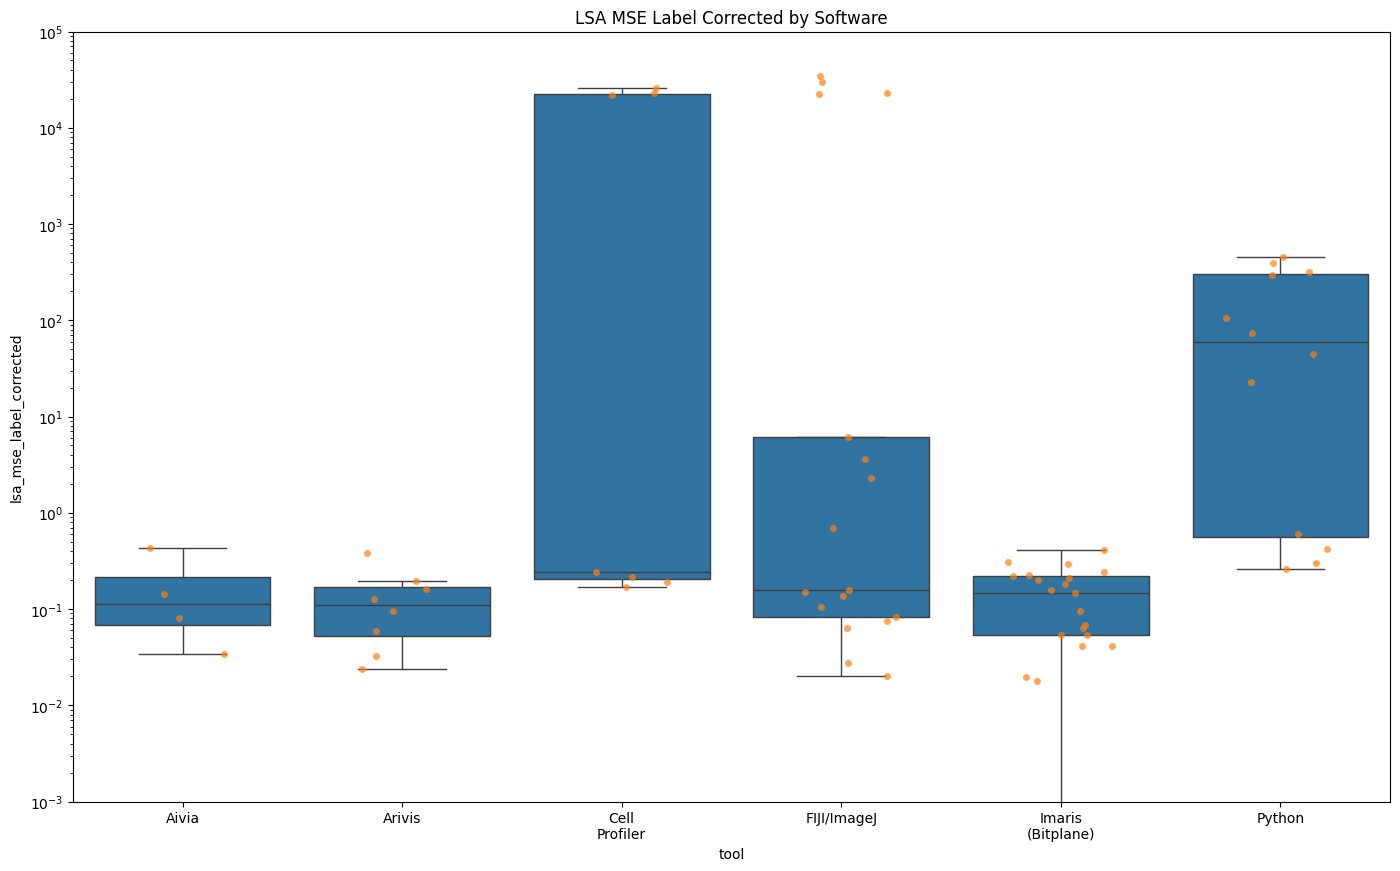

C:\Users\bnort\AppData\Local\Temp\ipykernel_20636\3078719350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tool'] = df["qx.2"].str.replace(' ', '\n')


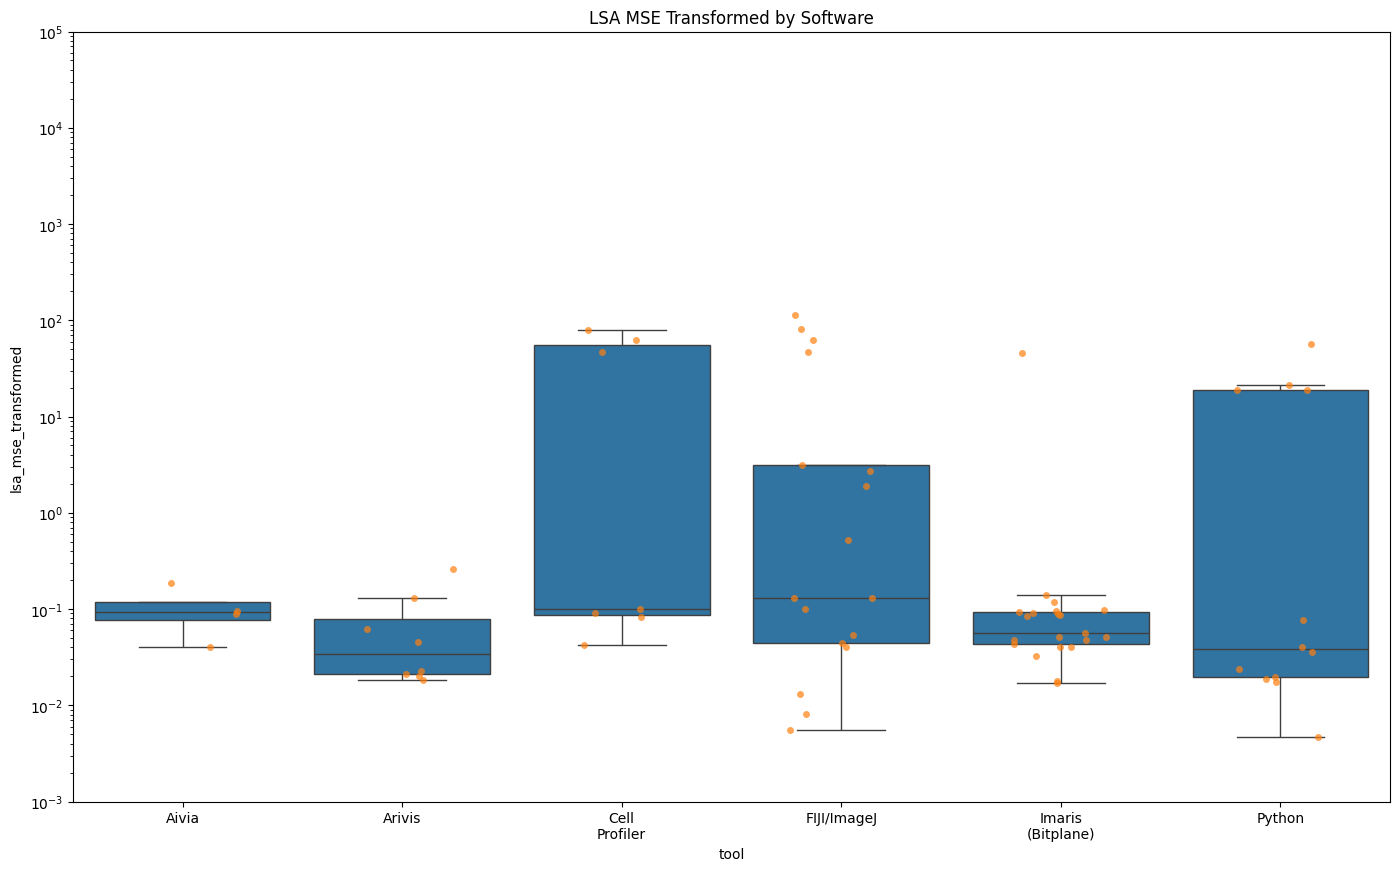

C:\Users\bnort\AppData\Local\Temp\ipykernel_20636\3078719350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tool'] = df["qx.2"].str.replace(' ', '\n')


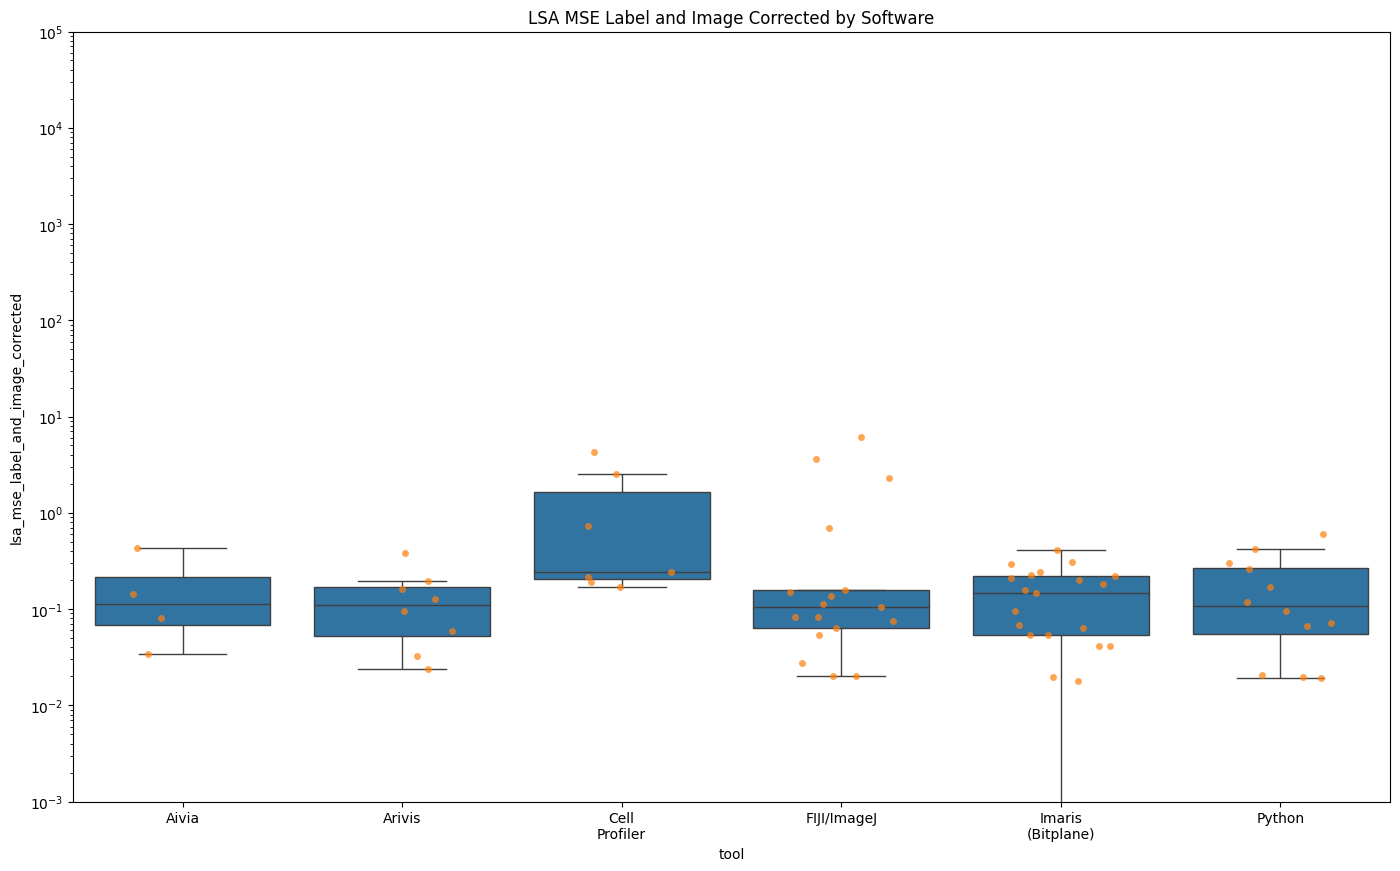

C:\Users\bnort\AppData\Local\Temp\ipykernel_20636\3078719350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tool'] = df["qx.2"].str.replace(' ', '\n')


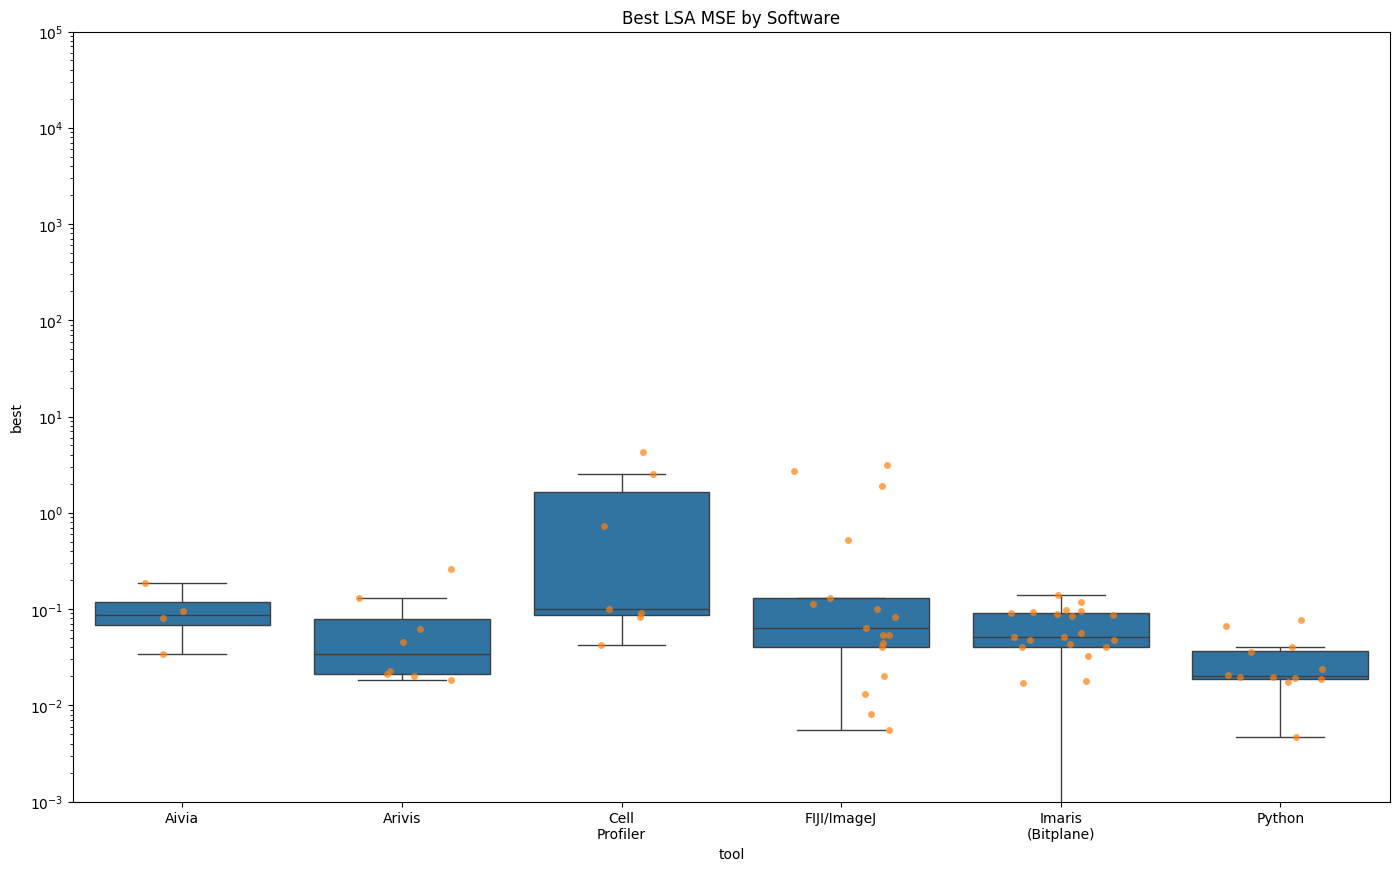

In [ ]:


def plot_softwares(df, col_name, title, log=True):
    plt.figure(figsize=(17, 10))
    df['tool'] = df["qx.2"].str.replace(' ', '\n')
    ordered_methods = sorted(df['tool'].unique())
    sns.boxplot(x='tool', y=col_name, data=df.dropna(), showfliers=False, order=ordered_methods)
    sns.stripplot(x='tool', y=col_name, data=df.dropna(), jitter=0.25, alpha=0.7)
    plt.yscale('log')
    plt.ylim(0.001, 100000)   
    plt.title(title)
    plt.savefig(os.path.join(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels', title), dpi=300)
    plt.show()
    
plot_softwares(df3, 'lsa_mse_raw', 'LSA MSE Raw by Software')
plot_softwares(df3, 'lsa_mse_label_corrected', 'LSA MSE Label Corrected by Software')
plot_softwares(df3, 'lsa_mse_transformed', 'LSA MSE Transformed by Software')
plot_softwares(df3, 'lsa_mse_label_and_image_corrected', 'LSA MSE Label and Image Corrected by Software')
plot_softwares(df3, 'best', 'Best LSA MSE by Software')

In [7]:

from scipy.__config__ import show
import seaborn as sns
import matplotlib.pyplot as plt



In [8]:

plt.figure(figsize=(17, 10))
ordered_methods = sorted(df3['tool'].unique())
sns.boxplot(x='tool', y='best', data=df3.dropna(),showfliers=False, order=ordered_methods)
sns.stripplot(x='tool', y='best', data=df3.dropna(), jitter=0.25, alpha=0.7)
plt.yscale('log')
plt.title('Box Plot of Score by Method')
plt.show()

NameError: name 'df3' is not defined

<Figure size 1700x1000 with 0 Axes>

In [42]:
df3.columns

Index(['responseid', 'qx.2', 'setName', 'lsa_mse_raw', 'lsa_mse_transformed',
       'lsa_mse_label_corrected', 'lsa_mse_label_and_image_corrected', 'best',
       'correction', 'jac'],
      dtype='object')

C:\Users\bnort\AppData\Local\Temp\ipykernel_33952\886420645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['qx.2'] = df4["qx.2"].str.replace(' ', '\n')
C:\Users\bnort\AppData\Local\Temp\ipykernel_33952\886420645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['qx.2'] = df4["qx.2"].str.replace(',', '\n')


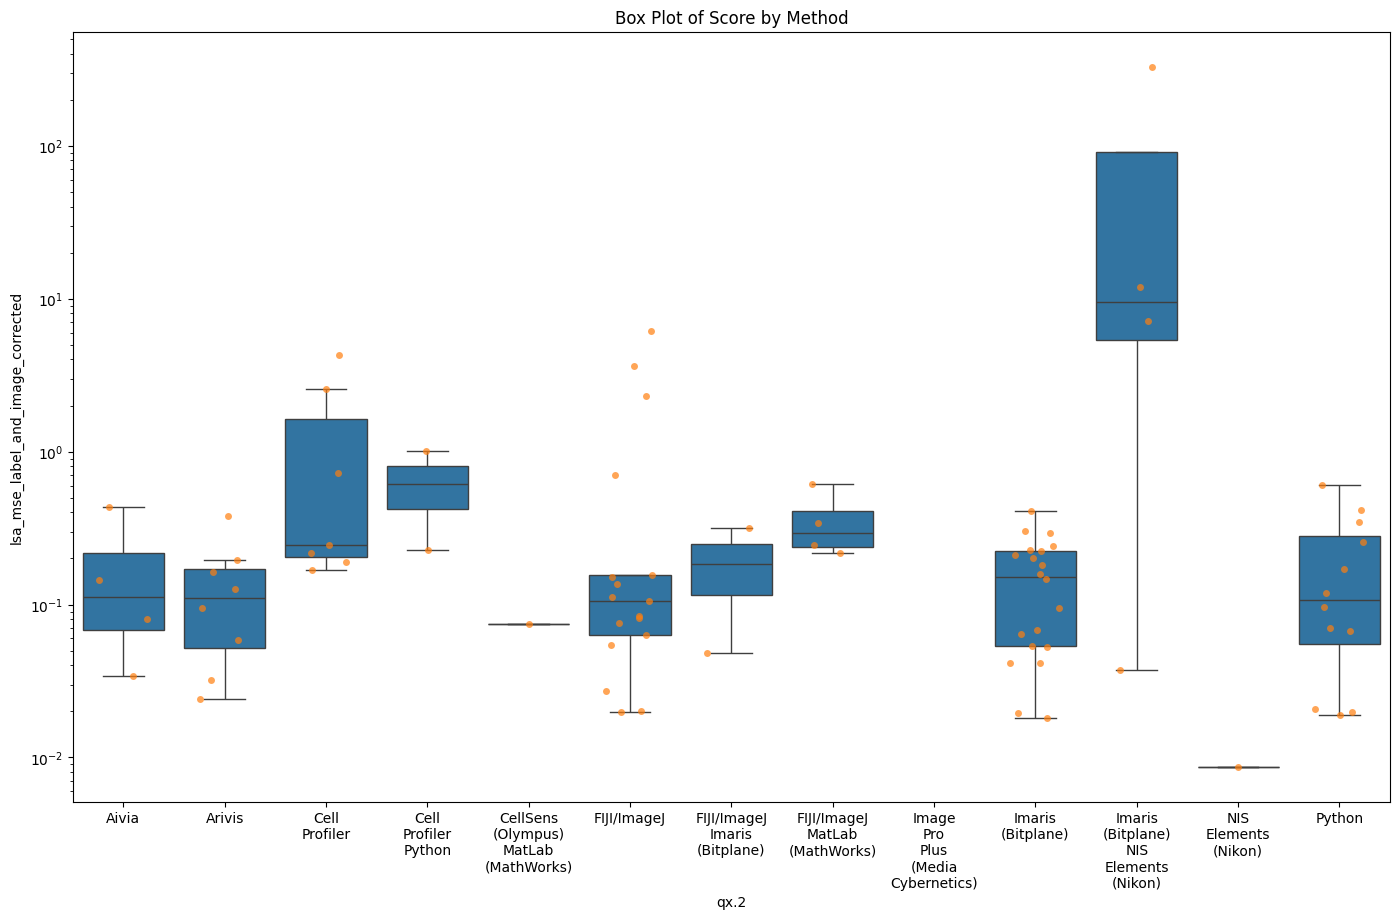

In [48]:

plt.figure(figsize=(17, 10))
df4= df3[df3.setName.str.contains('nuclei', na=False)]
df4['qx.2'] = df4["qx.2"].str.replace(' ', '\n')
df4['qx.2'] = df4["qx.2"].str.replace(',', '\n')
ordered_methods = sorted(df4['qx.2'].unique())
sns.boxplot(x='qx.2', y='lsa_mse_label_and_image_corrected', data=df4.dropna(),showfliers=False, order=ordered_methods)
sns.stripplot(x='qx.2', y='lsa_mse_label_and_image_corrected', data=df4.dropna(), jitter=0.25, alpha=0.7)
plt.yscale('log')
plt.title('Box Plot of Score by Method')
plt.show()

In [50]:
df3.head()

,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed,lsa_mse_label_corrected,lsa_mse_label_and_image_corrected,best,correction,jac,tool
0,R_31bjqd6Mm8wBxN5,Python,nuclei1,182.451824,56.679462,0.0,0.0,0.0,NONE,0.0,Python
1,R_31bjqd6Mm8wBxN5,Python,nuclei2,47.222279,21.174983,0.0,0.0,0.0,NONE,0.0,Python
2,R_31bjqd6Mm8wBxN5,Python,nuclei3,105.577865,18.732895,0.0,0.0,0.0,NONE,0.0,Python
3,R_31bjqd6Mm8wBxN5,Python,nuclei4,88.287150,19.067347,0.0,0.0,0.0,NONE,0.0,Python
4,R_3lAJ9xY4kGlL99f,Python,nuclei1,565.205858,0.017590,0.0,0.0,0.0,NONE,0.0,Python


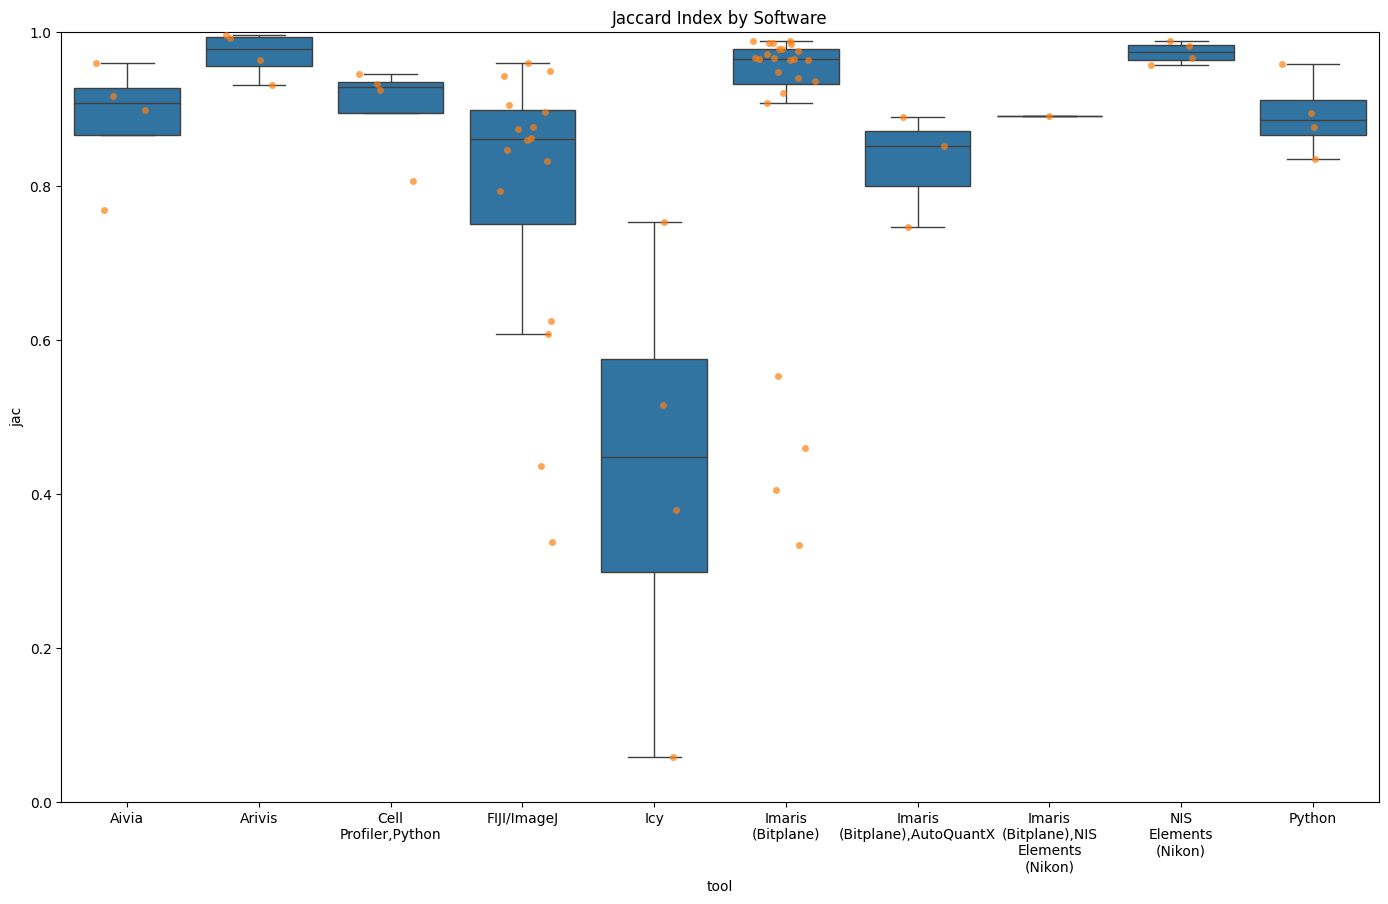

In [15]:
# Fish only
dffish = df3[df3['setName'].str.contains('fish', na=False)]
dffish = dffish[dffish['jac'] > 0]  # Filter out rows with jac <= 0

import matplotlib.pyplot as plt
def plot_softwares_jac(df, col_name, title):
    plt.figure(figsize=(17, 10))
    df['tool'] = df["qx.2"].str.replace(' ', '\n')
    ordered_methods = sorted(df['tool'].unique())
    sns.boxplot(x='tool', y=col_name, data=df, showfliers=False, order=ordered_methods)
    sns.stripplot(x='tool', y=col_name, data=df, jitter=0.25, alpha=0.7)
    plt.ylim(0, 1)   
    plt.title(title)
    plt.savefig(os.path.join(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels', title), dpi=300)
    plt.show()
    
plot_softwares_jac(dffish, 'jac', 'Jaccard Index by Software')

In [60]:
df3[df3['qx.2']=='Cell Profiler,Python']

,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed,lsa_mse_label_corrected,lsa_mse_label_and_image_corrected,best,correction,jac
123,R_0638fJAPpmzLtu1,"Cell Profiler,Python",nuclei1,33946.444950,114.068490,0.000000,0.000000,0.000000,NONE,0.000000
124,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",nuclei1,28.194606,0.397946,0.000000,0.000000,0.000000,NONE,0.000000
125,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",nuclei2,NaN,NaN,0.000000,0.000000,0.000000,NONE,0.000000
126,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",nuclei3,NaN,NaN,0.000000,0.000000,0.000000,NONE,0.000000
127,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",nuclei4,NaN,NaN,0.000000,0.000000,0.000000,NONE,0.000000
128,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",fish1,0.962879,5.676291,1.720038,1.720038,1.720038,NONE,0.976173
129,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",fish2,NaN,NaN,8.438301,8.438301,8.438301,NONE,0.790698
130,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",fish3,NaN,NaN,1.722837,1.722837,1.722837,NONE,0.952315
131,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",fish4,NaN,NaN,2.822022,2.822022,2.822022,NONE,0.929598
